Z factor computation with split energies
-----------------------------------------------------

In [1]:
%load_ext autoreload
%autoreload 2
import CBcm

In [2]:
from copy import deepcopy
import pickle, os, sys

In [3]:
sys.path.append('/home/jp/projects/ipython_notebooks/MCEq/prd_paper_2021/plot_scripts_anatoli')
sys.path.append('/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules')
import mufit_config, quickflux

In [4]:
import sys
sys.path.insert(0, '/home/jp/software/MCEq')

In [5]:
outdir = '/home/jp/projects/atm_nu/ddm_results/daemon_prd_submission'
if not os.path.isdir(outdir):
    os.mkdir(outdir)

In [6]:
import matplotlib.pyplot as plt
import numpy as np

#import solver related modules
from MCEq.core import MCEqRun
import mceq_config as config
#import primary model choices
import crflux.models as pm

import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 150


/home/jp/software/MCEq/mceq_config.py:309: FutureWarning: Config dictionary is deprecated. Use 'import mceq_config as config' instead of 'from mceq_config import config'; and 'config.variable instead of config['variable']
  warnings.warn(warn_str, FutureWarning)


In [7]:
mceq_ddm = MCEqRun(
#provide the string of the interaction model
interaction_model='DPMJETIII191',
#primary cosmic ray flux model
primary_model = (pm.SimplePowerlaw27, None),
# Zenith angle in degrees. 0=vertical, 90=horizontal
theta_deg=0.0
)

/home/jp/software/MCEq/MCEq/data/mceq_db_lext_dpm191_v131.h5
MCEqRun::set_interaction_model(): DPMJETIII191
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): Primary model set to $E^{-2.7}$


In [8]:
### Getting the rest of the models for the Z-factor plot

base_model = 'DPMJETIII191'
# config.mceq_db_fname = 'mceq_db_lext_dpm191_v131.h5'
config.enable_default_tracking = False
config.adv_set['fix_dpmjet_neutral_kaons'] = True
mceq = MCEqRun(
    interaction_model=base_model,
    theta_deg=0.,
    primary_model=(pm.SimplePowerlaw27,None))
mceq_sibyll = MCEqRun(
    interaction_model='SIBYLL23C',
    theta_deg=0.,
    primary_model=(pm.SimplePowerlaw27,None))
mceq_epos = MCEqRun(
    interaction_model='eposlhc',
    theta_deg=0.,
    primary_model=(pm.SimplePowerlaw27,None))
mceq_qgs = MCEqRun(
    interaction_model='qgsjetii04',
    theta_deg=0.,
    primary_model=(pm.SimplePowerlaw27,None))

/home/jp/software/MCEq/MCEq/data/mceq_db_lext_dpm191_v131.h5
MCEqRun::set_interaction_model(): DPMJETIII191
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): Primary model set to $E^{-2.7}$
/home/jp/software/MCEq/MCEq/data/mceq_db_lext_dpm191_v131.h5
MCEqRun::set_interaction_model(): SIBYLL23C
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): Primary model set to $E^{-2.7}$
/home/jp/software/MCEq/MCEq/data/mceq_db_lext_dpm191_v131.h5
MCEqRun::set_interaction_model(): EPOSLHC
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): Primary model set to $E^{-2.7}$
/home/jp/software/MCEq/MCEq/data/mceq_db_lext_dpm191_v131.h5
MCEqRun::set_interaction_model(): QGSJETII04
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): Primary model set to $E^{-

In [9]:
from references import Honda2006ZFactors
honda_zfac = Honda2006ZFactors(floc='/home/jp/projects/atm_nu/plot_scripts_anatoli/Sanuki_Honda_2006_ZFactors.csv')

Define variables and angles
-------------------------

In [10]:
#Power of energy to scale the flux (the results will be returned as E**mag * flux)
mag = 3

#obtain energy grid (fixed) of the solution for the x-axis of the plots
e_grid = mceq_ddm.e_grid

#Dictionary for results
flux = {}

#Define a zenith angle, counted positively from vertical direction. Theta = 0. means vertical, theta = 90. horizontal
theta = 60.

## Creating or loading the original DDM Z-factors

In [11]:
from MCEq.ddm import DataDrivenModel
from os.path import join

In [12]:
ddm = DataDrivenModel(
    join(config.data_dir, 'CarbonTargetFits_inclna49K_pp2pC4.npy'))

In [13]:
#print(ddm)

Here needs to go the energy of what we have chosen for the extrapolation point

In [14]:
for prim, sec in ddm.channels:
    if prim != 2212:
        continue
    ddm.clone_datapoint(prim, sec, 158, 2e4)
    #ddm.clone_datapoint(prim, sec, 158, 2e5)
    ddm.clone_datapoint(prim, sec, 158, 2e6)
ddm.clone_datapoint(prim, 2212, 158., 31.0)
ddm.clone_datapoint(prim, -2212, 158., 31.0)
ddm.clone_datapoint(prim, 2112, 158., 31.0)


In [15]:
# Inject DDM in MCEq
mceq_ddm.inject_ddm(ddm)

In [16]:
secs = [211, -211, 321, -321, 2212, 2112, 310]
#zfac_fname = 'zfac_ddm_original_splitvhe_lepn.pkl'
zfac_fname_original = '/home/jp/projects/atm_nu/plot_scripts_anatoli/zfac_ddm_original_splitvhe.pkl' #This contains the LE stuff
zfac_fname = 'zfac_lib_smart.pkl' # The new one


In [17]:
# if os.path.isfile(zfac_fname):
#     zfac_lib = pickle.load(open(zfac_fname, 'rb'))
# if os.path.isfile(zfac_fname_original):
#     zfac_ddm_original = pickle.load(open(zfac_fname_original,'rb'))
    
# Do the common settings instead
common_settings = pickle.load(open('/home/jp/projects/atm_nu/ddm_results/final_settings/common_settings_daemon.pkl', 'rb'))
zfac_lib = common_settings['zfactors_labeled']

## Getting the Z-factors from the fits

In [18]:
def plotZfac(zfac_ddm_cal_list, 
            plot_other_models = True,
            ylim_scale = 2,
            #err_scale = {'pi+':2, 'pi-':5, 'K+':7 , 'K-':10 , 'p':4, 'n':2}
            ):
    ddm_color = "violet"
    ddm_extension = "0.8" #"darkgreen"
    for m in [mceq_ddm]:
        m.set_primary_model(pm.SimplePowerlaw27())
    # plot_impy_direct = False
    # plot_other_models = True
    # plot_honda = True
    fs = 12
    secs = [211, -211, 321, -321, 2212, 2112, 310]
    secs_label = ['pi+','pi-','K+','K-','p','n','K0']
    elabels = ['31G','158G','20T','2P']
    pdg2name = {
        211: r"$\pi^+$",
        -211: r"$\pi^-$",
        321: r"K$^+$",
        -321: r"K$^-$",
        2212: r"p",
        -2212: r"$\bar{\rm p}$",
        2112: r"n",
        310: r"K$^0_S$",
        130: r"K$^0_L$",
    }
    particle_labels = {
        211: r"$\pi^+$",
        -211: r"$\pi^-$",
        321: r"K$^+$",
        -321: r"K$^-$",
        2212: r"p+$\bar{\rm p}$",
        2112: r"n+$\bar{\rm n}$",
        310: r"K$^0_S$+K$^0_L$",
    }
    colors = ["C1", "C2", "C3", "C4", "C6"]

    
    #print(zfac_ddm_cal_list)
    ref_errors = list(zfac_ddm_cal_list.keys())[0]
    print('Using reference errors from fit', ref_errors)

    def add_zfactor(mceq_obj, prim, sec1, sec2=None):
        if sec2 is not None:
            return mceq_obj.z_factor(prim, sec1, use_cs_scaling=False) + mceq_obj.z_factor(
                prim, sec2, use_cs_scaling=False
            )
        else:
            return mceq_obj.z_factor(prim, sec1, use_cs_scaling=False)




    fig, axes = plt.subplots(2, 4, sharex=True, figsize=(9, 4.7))
    ms = 4
    prim = 2212
    r = [321, -321, -2212]
    #secs = [211, -211, 321, -321, 2212, 2112, 310]
    for i, seci in enumerate(secs):
        ax = axes.flatten()[i]  # [i//3, i%3]

        norm = 1.0  # zair[2]

        if seci == 2212:
            sec2 = -2212
        elif seci == 2112:
            sec2 = -2212
        elif seci == 310:
            sec2 = 130
        else:
            sec2 = None

        # DDM model
        #ddm_zfac = add_zfactor(mceq_ddm, prim, seci, sec2)
        #print(ddm_zfac)
        ax.semilogx(
            mceq_ddm.e_grid,
            add_zfactor(mceq_ddm, prim, seci, sec2),
            c="violet",
            lw=3,
            alpha=0.8,
            label="DDM in MCEq, no tune" if i == 0 else "_nolabel_",
        )
        
        if plot_other_models:
            sel = np.where(mceq.e_grid > 80)
            ax.semilogx(mceq.e_grid[sel], add_zfactor(mceq_sibyll, prim, seci, sec2)[sel]/norm,c=colors[0], ls='-', 
                        label='SIBYLL-2.3d' if i == 0 else '_nolabel_')
            sel = np.where(mceq.e_grid > 5.)
            ax.semilogx(mceq.e_grid[sel], add_zfactor(mceq, prim, seci, sec2)[sel]/norm,c=colors[1],
                        label='DPMJET-III 19.1' if i == 0 else '_nolabel_')
            sel = np.where(mceq.e_grid > 30.)
            ax.semilogx(mceq.e_grid[sel], add_zfactor(mceq_epos, prim, seci, sec2)[sel]/norm,c=colors[2], 
                        label='EPOS-LHC' if i == 0 else '_nolabel_')
            sel = np.where(mceq.e_grid > 100)
            ax.semilogx(mceq.e_grid[sel], add_zfactor(mceq_qgs, prim, seci, sec2)[sel]/norm,c=colors[3], 
                        label='QGSJET-II-04' if i == 0 else '_nolabel_')
        if seci != -2212 and prim == 2212:# and plot_honda:
            ax.semilogx(*honda_zfac.get_data(pdgid=seci),c=colors[4],ls='-',label='HKKMS' if i == 0 else '_nolabel_')
            
        ax.set_xticks([1.0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7])
        ax.set_ylim(-ax.get_ylim()[1] / 20, ylim_scale * ax.get_ylim()[1])
        ax.set_xlim(10, 3e7)
        if i < 4:
            ax.text(0.05, 0.05, particle_labels[seci], transform=ax.transAxes, fontsize=14)
        elif i < 6:
            ax.text(0.05, 0.05, particle_labels[seci], transform=ax.transAxes, fontsize=14)
        else:
            ax.text(0.05, 0.05, particle_labels[seci], transform=ax.transAxes, fontsize=14)
        ax.tick_params(bottom=True, top=True, left=True, right=True, direction="in")

        
        # The points from DDM
        r = pickle.load(open(calibration_results[ref_errors], 'rb'), encoding='latin1')
        for ien, ena in enumerate([31, 158, 2e4, 2e6]):
            this_label = secs_label[i]+'_'+elabels[ien]
#             if ena > 200:
#                 if ena < 1E6 and ('pi' not in secs_label[i]):
#                     continue
#                 this_label = 'vhe3_'+secs_label[i]
#             else:
#                 this_label = elabels[ien] + secs_label[i]
            if this_label in zfac_lib:
                (valj, errj) = zfac_lib[this_label]
                if ena > 200:
                    error_scaling = r['flux_parameters'][this_label][-1]
                    print('Error scale', this_label, error_scaling)
                    thiscolor= ddm_extension
                else:
                    error_scaling = 1
                    thiscolor = ddm_color
                
                # Scale the errj to my estimates
                ax.errorbar(
                    ena,
                    valj,
                    yerr=errj*error_scaling,
                    marker="o",
                    markersize=4,
                    color=thiscolor,
                    label="NA49 & NA61" if i == 3 and ien == 0 else "_nolabel_",
                )    
        
            
                
        for it, tune in enumerate(zfac_ddm_cal_list):
            # Open the file
            result = pickle.load(open(calibration_results[tune], 'rb'), encoding='latin1')['params']
            for ien, ena in enumerate([31, 158, 2e4, 2e6]):
                this_label = secs_label[i] +"_"+elabels[ien]

                if this_label in result:
                    valjcal = (zfac_lib[this_label][0]+
                               zfac_lib[this_label][1]*result[this_label]['value'])
                    errjcal = zfac_lib[this_label][1]*result[this_label]['error']

                    #print(this_label, valjcal, errjcal)
                    ax.errorbar(
                        ena*(1+it/4.),
                        valjcal,
                        yerr=errjcal,
                        marker="o",
                        markersize=4,
                        color="C"+"%i" % it,
                        label= tune if i == 3 and ien == 0 else "_nolabel_",
                        zorder=9
                    )

                    #print(i, ien, i == 3 and ien == 0)
                    

        if i // 4 == 1:
            ax.set_xlabel(r"$E_p$ [GeV]", fontsize=fs - 1)
        elif i == 3:
            ax.set_xlabel(r"$E_p$ [GeV]", fontsize=fs - 1)
        else:
            ax.xaxis.set_ticklabels([])

        if i % 4 == 0:
            ax.set_ylabel(r"$Z_{p,\mathrm{sec}}$", fontsize=fs)


    for ax in axes.flatten():
        ax.tick_params(axis="both", which="major", labelsize=fs - 3)

    axes[-1, -1].set_visible(False)
    axes[-1, 0].set_xticks([1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7])

    fig.legend(
        fontsize=fs - 2,
        frameon=False,
        ncol=1,
        bbox_to_anchor=(0.985, 0.48),
        bbox_transform=fig.transFigure,
        title="Proton-air",
    )

    fig.tight_layout(w_pad=-0.05, h_pad=-1)
    plt.subplots_adjust(wspace=0.3)
    # plt.subplots_adjust(top = 0.9)
    plt.savefig("DDM_tune_Zfactors_splitVHE.png", dpi=200)
    return fig
    # plt.savefig('../../figures/zfactors_protons.png', dpi=300)
    # plt.savefig('../../figures/zfactors_protons.pdf')
    # fig.savefig('/Users/mhuber/AtmosphericShowers/Paper_hadronic_Flux_uncertainties/Plots/Zfactors_2212_impy_sibyll_norm.pdf',
    #    bbox_inches="tight")


In [19]:
my_params = ['scale','GSF_1','GSF_2',
                   'GSF_3','GSF_4',
                   'GSF_5','GSF_6']

my_params = ['K+_158G', 'K+_2P', 'K+_31G', 'K-_158G', 'K-_2P', 'K-_31G', 'n_158G', 'n_2P', 
                   'p_158G', 'p_2P', 'pi+_158G', 'pi+_20T', 'pi+_2P', 'pi+_31G', 
                   'pi-_158G', 'pi-_20T', 'pi-_2P', 'pi-_31G']
# my_params = ['l3c_align',
#                    'l3c_bfield',
#                    'l3c_eloss',
#                    'l3c_overb',
#                    'l3c_normHor',
#                    'l3c_normVert',
#                    'l3c_pres',
#                    'mn_escale',
#                    'bess_align',
#                    'bess_finres']
nparams = len(my_params)
def resultSummary(calfiles):
    fig = plt.figure(figsize=(10,4))
    chi2_list = np.zeros(len(calfiles))
    cal_names = []
    for ires, fresult in enumerate(calfiles):
        if calfiles[fresult] == '':
            continue
        with open(calfiles[fresult], 'rb') as data_file:
            result = pickle.load(data_file, encoding='latin1')
        cal_names.append(fresult)
        chi2_list[ires] = result['chi2']
        test_params = {}
        values = np.zeros(nparams)
        errors = np.zeros_like(values)
        for iphys, one_phys in enumerate(my_params):
            if one_phys in result['params']:
                values[iphys] = result['params'][one_phys]['value']
                errors[iphys] = result['params'][one_phys]['error']
                
        plt.errorbar(np.arange(len(my_params))+0.1*ires,
                 values, errors, fmt='+', label=fresult)
    _ = plt.xticks(range(nparams), 
                       my_params, rotation='vertical')
    
    plt.legend(loc=0)
    plt.ylim(-4,4)
    
    
    fig = plt.figure(figsize=(10,4))
    plt.plot(np.arange(chi2_list.size),
            chi2_list, 'x')
    _ = plt.xticks(range(chi2_list.size), 
                    cal_names, rotation='vertical')     
    plt.ylabel('Chi2')
    
    return fig
    #plt.ylim(-1,1)

In [20]:

# Comparison between multiplicative and additive systematic approach
calibration_results = {
    #'ddmgsf':'/home/jp/projects/atm_nu/ddm_results/prd22_qf2_v19_final.pkl',
    #'ddmgsf_bess':'/home/jp/projects/atm_nu/ddm_results/prd22_qf2_v19hybrid.pkl',
    #'daemonflux4': '/home/jp/projects/atm_nu/ddm_results/prd22_daemon_v4.pkl',
    #'daemonflux': '/home/jp/projects/atm_nu/ddm_results/prd22_daemon_v5.pkl',
    'daemonflux': '/home/jp/projects/atm_nu/ddm_results/daemon_prd_submission.pkl'
}


MCEqRun::set_primary_model(): Primary model set to $E^{-2.7}$
Using reference errors from fit daemonflux
Error scale pi+_20T 1.8
Error scale pi+_2P 1.8
Error scale pi-_20T 10
Error scale pi-_2P 10
Error scale K+_2P 10
Error scale K-_2P 20.0
Error scale p_2P 6
Error scale n_2P 2.5


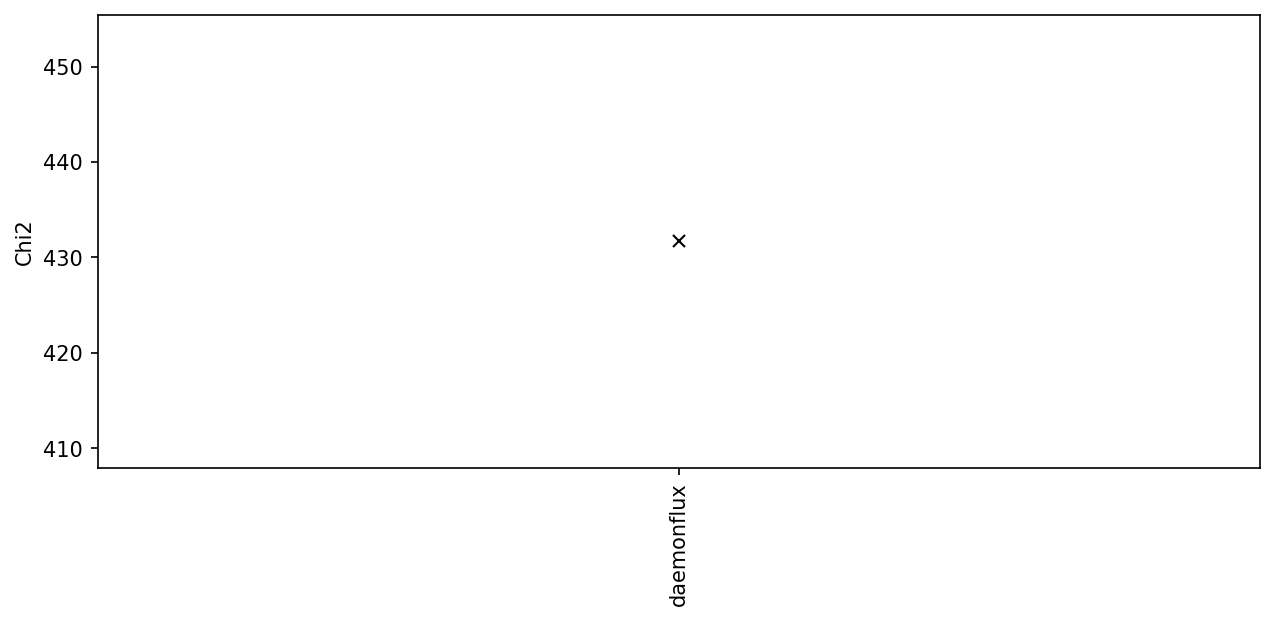

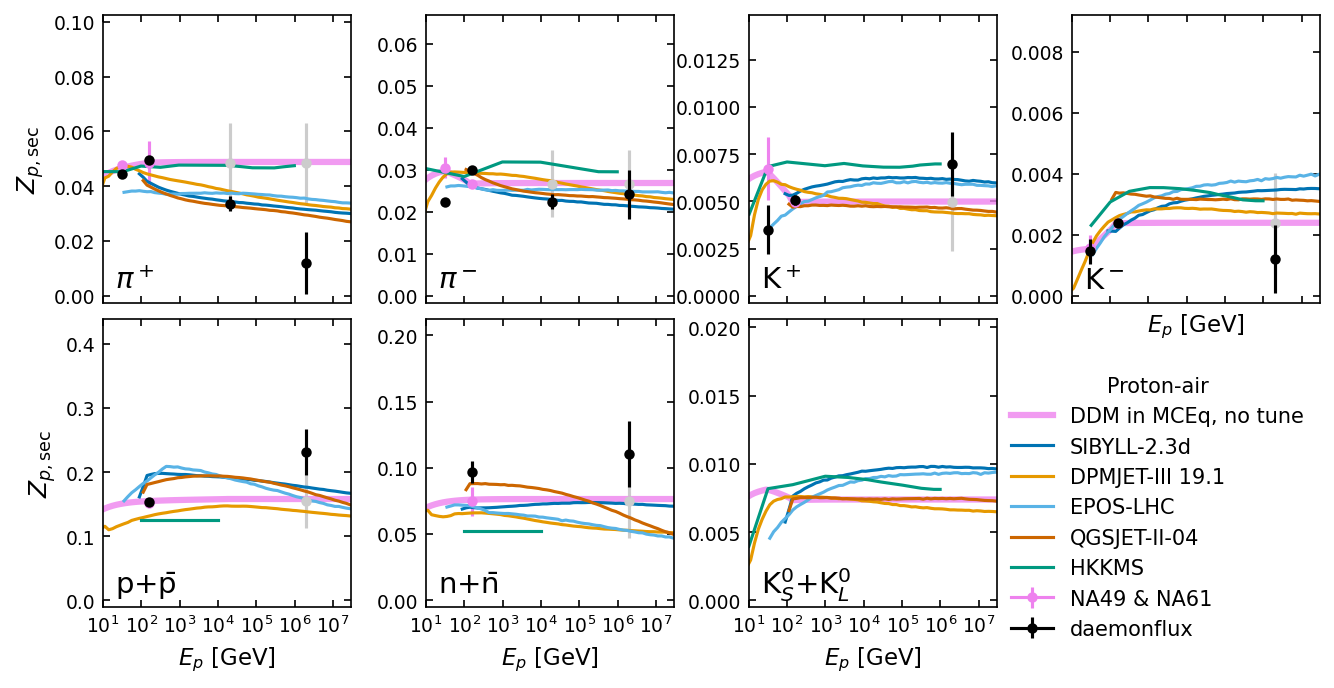

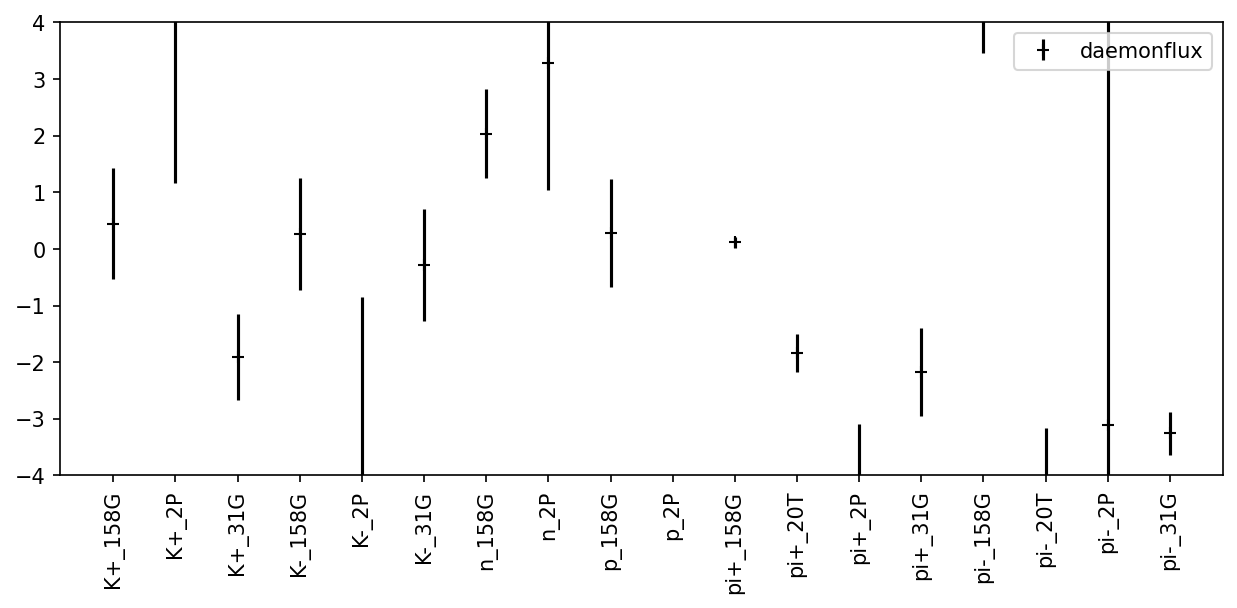

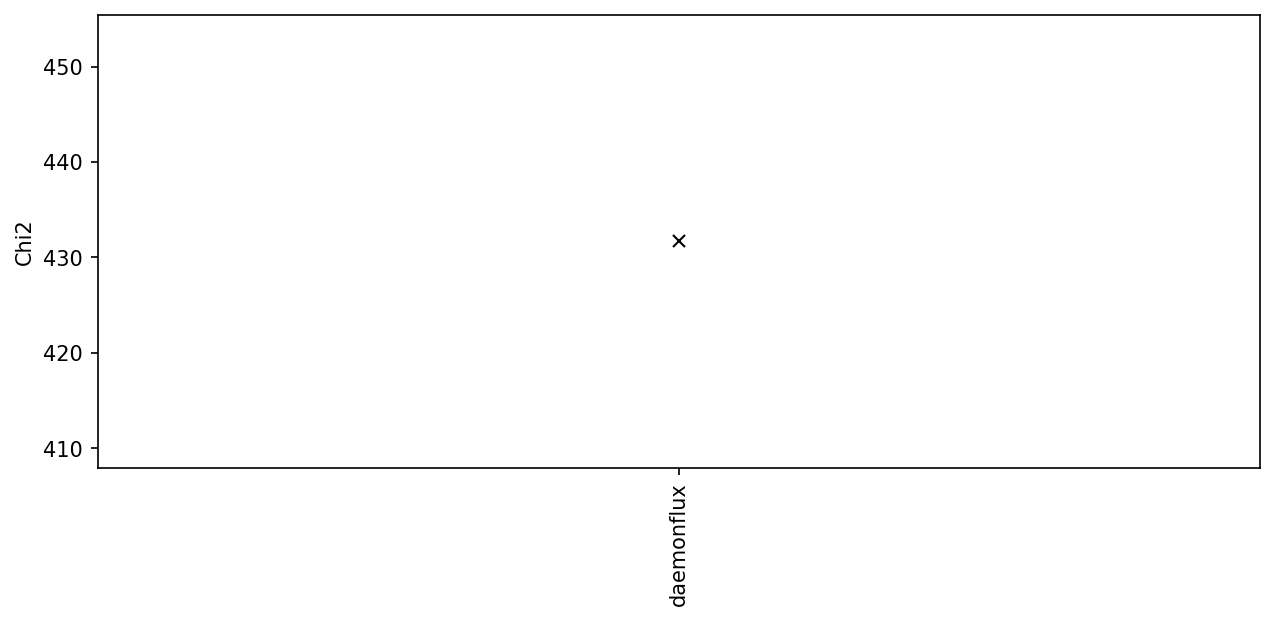

In [21]:
#zfacs = makeZfac(calibration_results)
fig = plotZfac(calibration_results,
         plot_other_models = True,
        ylim_scale=2.)
            #err_scale = {'pi+':2.5, 'pi-':10, 'K+':10 , 'K-':20 , 'p':6, 'n':2.5})
fig.savefig(os.path.join(outdir, 'zfactors_daemon.pdf'))
resultSummary(calibration_results)

In [25]:
calibration_results.get(0)

#### Still need to add a loop to include multiple models in the test

In [26]:
#calibration_results = {}
#calibration_results.update({'DDM+GSF':''})

In [27]:
# Global plot configuration

fs = 16
fs_ticks = 16
alpha_mod = .15
data_marker_config = {'lw':1, 'linestyle':'None', 'alpha':.8, 'markersize':3.}
#colors = ['black', 'blue', 'orange', 'green', 'red', 'grey', 'pink']
#norm = Normalize(0,10)
#s_m = cm.ScalarMappable(cmap=cm.magma, norm=norm)
#s_m.set_array([])
#colors = [s_m.to_rgba(i) for i in range(10)]

In [28]:
import quickflux2
qflux_ddmgsf = quickflux2.MCEq_fastflux(flux_tables='ddmgsf-v19')
qflux_daemon = quickflux2.MCEq_fastflux(flux_tables='daemon-v3')

/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/resources/DDM_splines_20221115_newstyle_smarter.pkl
Excluded params removed from known_params.
No calibration file for ddmgsf-v19
Adjusting DEIS name
/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/resources/daemonsplines_20230207_nousertab.pkl
Excluded params removed from known_params.
No calibration file for daemon-v3
Adjusting DEIS name


In [29]:
def comparePlots(calfiles,
                reference = 'ddmgsf',
                particle = 'numuflux'):
    #reference = 'CAL_2E'
    #particle = 'numuflux'
    exp = 'cms'
    angle = '0.0000'

    fluxes = []
    errors = []
    keys   = []

    mag=3
    egrid = np.logspace(-1,5.99)


    # Load all the fluxes
    refindex = None
    for ires, fresult in enumerate(calfiles):
        
        if 'daemon' in fresult:
            print('Using DAEMON quickflux')
            qflux = qflux_daemon
        else:
            qflux = qflux_ddmgsf
        
        keys.append(fresult)
        if reference == fresult:
            refindex = ires
            
        #print(keys[-1])

        if calfiles[fresult] == '':
            # Use default spline
            fluxes.append(qflux.get_flux_new(egrid, exp, angle, particle, use_calibration = False))
            errors.append(qflux.get_error_new(egrid, exp, angle, particle, use_calibration = False))

        else:
            print(fresult)
            with open(calfiles[fresult], 'rb') as data_file:
                result = pickle.load(data_file, encoding='latin1')

            # Splines path
            splines_path = result['flux_tables']
#             splines_path = os.path.join(mufit_config.jacobians_dir,
#                                         mufit_config.jacobians[result['flux_tables']])

            # Set up the quickflux calibration file and 
            #print(keys[ires], calfiles[fresult], splines_path)
            
            qflux.set_mufit_spl(splines_path)
            qflux.set_calibration_file(calfiles[fresult])
           # print(quickflux._calibration_file)
            #quickflux.load_splines()
            
            
            fluxes.append(deepcopy(qflux.get_flux_new(egrid, exp, angle, 
                                                 particle, 
                                                 use_calibration=True)))
            
            errors.append(qflux.get_error_new(egrid, exp, angle, 
                                                  particle, 
                                                  use_calibration=True))
            
            #print(quickflux.cal_values)
    ## Plotting all the fluxes here
    
    ## TOP plot, the fluxes
    fig, axes = plt.subplots(
        3, 1, figsize=(5.5, 8.5), sharex=True, gridspec_kw={"height_ratios": (1, 1,1)}
    )
    ax = axes[0]

    #ax.set_ylabel(r"($E$/GeV)$^3~\Phi_{\nu_\mu}$ (GeV cm$^{2}$ s sr)$^{-1}$", fontsize=fs - 4)
    ax.set_ylabel(particle)

    #print(keys)
    for ires in range(len(keys)):

        ax.fill_between(egrid, fluxes[ires] + errors[ires], fluxes[ires] - errors[ires], 
                        facecolor="C"+"%i" % ires, alpha=alpha_mod, label=keys[ires])
        ax.plot(egrid, fluxes[ires], ls="solid", color="C"+"%i" % ires, 
                alpha=0.8)

    ## Calibrated DDM+GSF
    #ax.fill_between(egrid, flux_cal + err_cal, flux_cal - err_cal, 
    #                facecolor="r", alpha=alpha_mod)
    #ax.plot(egrid, flux_cal, ls="-.", color="r", alpha=0.8)

    ax.set_xscale("log")

    if not 'ratio' in particle:
        ax.set_yscale("log")
        ax.set_ylim(2e-4, 1.5e-1)


    ax.set_xlim(0.1, 9e5)
    ax.tick_params(
        axis="both",
        which="both",
        right=True,
        top=True,
        direction="inout",
        labelsize=fs_ticks - 5,
    )
    
    
    
    # ## MIDDLE figure - ratios    
    ax = axes[1]
    for ires in range(len(keys)):
        #print(fluxes[ires]/fluxes[refindex])
        ax.semilogx(egrid, fluxes[ires]/fluxes[refindex],
                   c="C"+"%i" % ires, ls='-')
        ax.fill_between(egrid,
                        (fluxes[ires]+errors[ires])/fluxes[refindex],
                        (fluxes[ires]-errors[ires])/fluxes[refindex],
                       facecolor = "C"+"%i" % ires,
                       alpha=alpha_mod, label=keys[ires])

    ax.set_ylabel("Model/"+keys[refindex])
    #ax.set_xlabel(r"$E_{\nu_{\mu}}$ (GeV)", fontsize=fs - 4)
    ax.set_ylim(0.8, 1.2)
    
    
    ax = axes[2]
    for ires in range(len(keys)):
        #print(fluxes[ires]/fluxes[refindex])
        ax.semilogx(egrid, errors[ires]/fluxes[ires],
                   c="C"+"%i" % ires, ls='-', label=keys[ires])

    ax.set_ylabel("Model error")
    ax.set_xlabel(r"$E_{\nu_{\mu}}$ (GeV)", fontsize=fs - 4)    
    plt.tight_layout(h_pad=-0.5)
    plt.legend(loc=0)



In [32]:
#calibration_results.update({'DDM+GSF':''})
myref = 'daemonflux4'

Using DAEMON quickflux
daemonflux4
/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/resources/daemonsplines_20230207_nousertab.pkl
Excluded params removed from known_params.
No calibration file for daemon-v3
Using DAEMON quickflux
daemonflux5
/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/resources/daemonsplines_20230207_nousertab.pkl
Excluded params removed from known_params.
No calibration file for daemon-v3


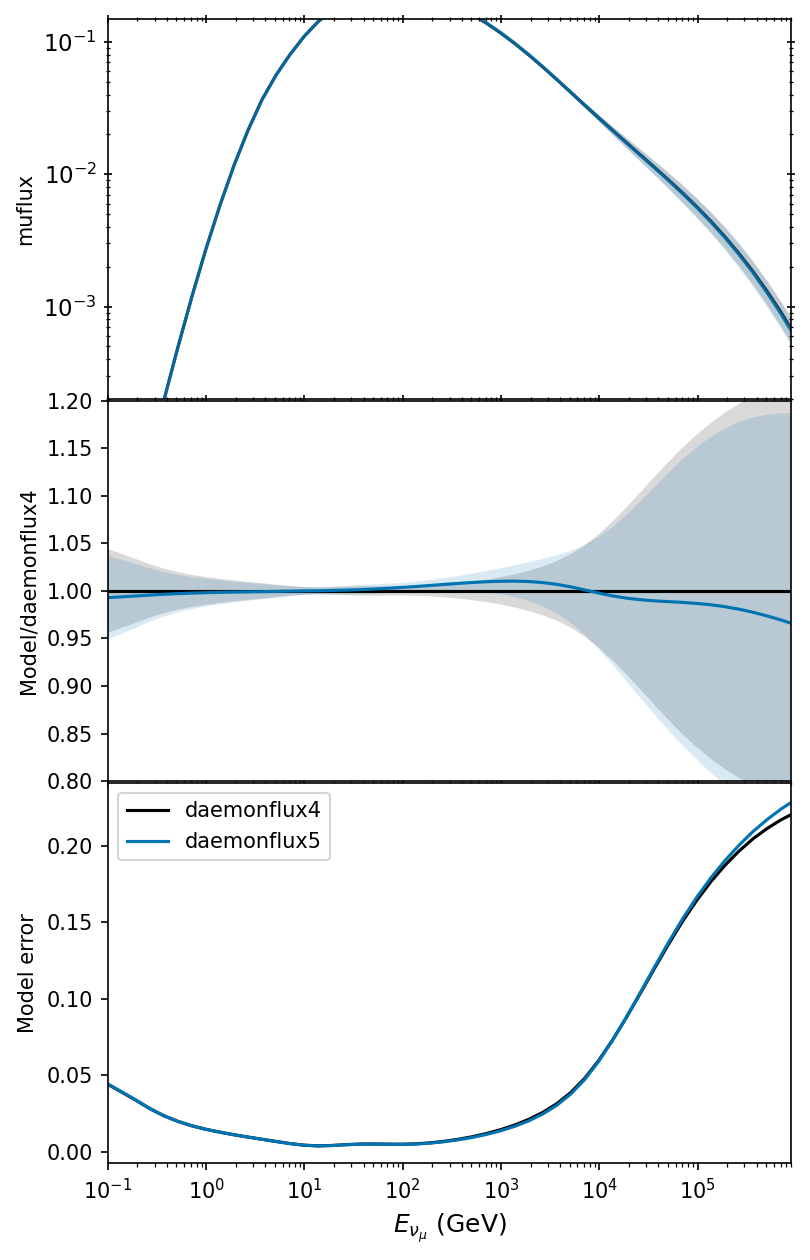

In [33]:
comparePlots(calibration_results, 
             reference=myref,
            particle = 'muflux')

Using DAEMON quickflux
daemonflux4
/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/resources/daemonsplines_20230207_nousertab.pkl
Excluded params removed from known_params.
No calibration file for daemon-v3
Using DAEMON quickflux
daemonflux5
/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/resources/daemonsplines_20230207_nousertab.pkl
Excluded params removed from known_params.
No calibration file for daemon-v3


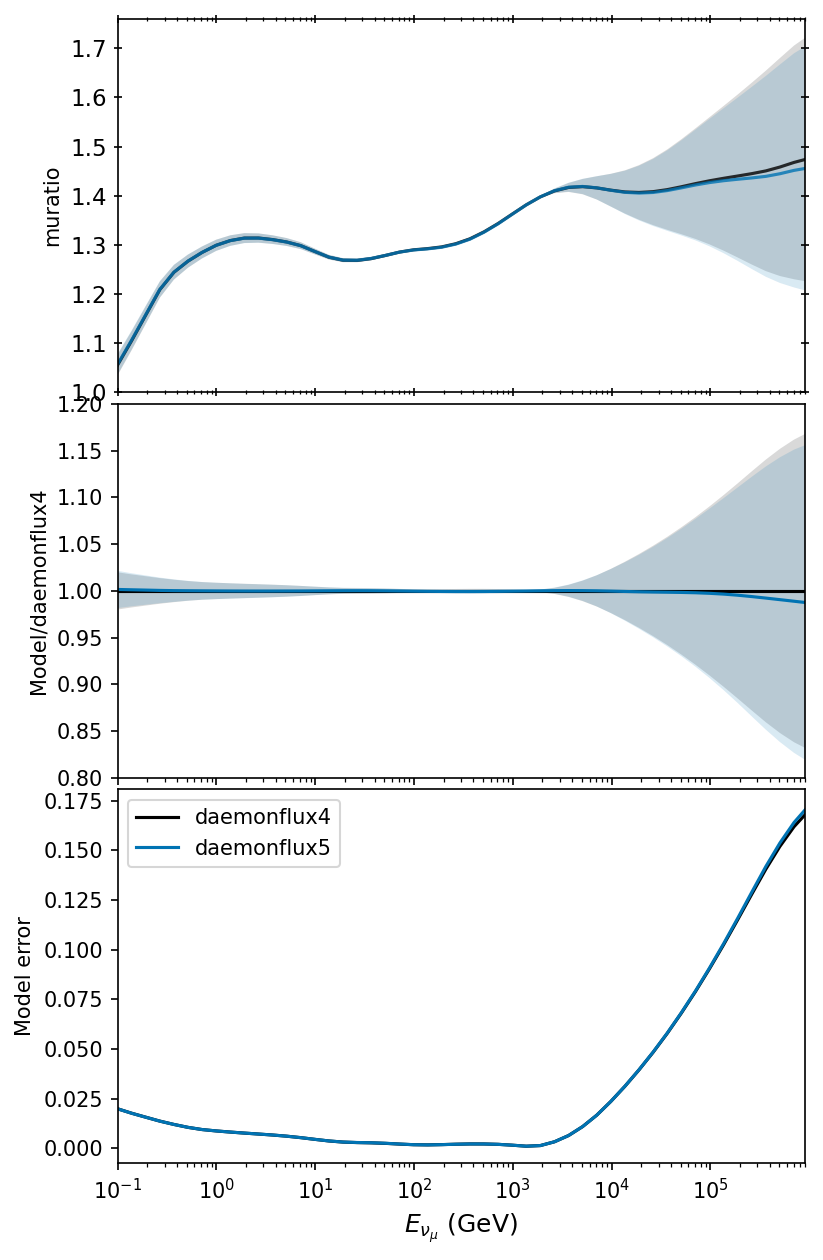

In [34]:
comparePlots(calibration_results, 
             reference=myref,
            particle = 'muratio')

Using DAEMON quickflux
daemonflux4
/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/resources/daemonsplines_20230207_nousertab.pkl
Excluded params removed from known_params.
No calibration file for daemon-v3
Using DAEMON quickflux
daemonflux5
/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/resources/daemonsplines_20230207_nousertab.pkl
Excluded params removed from known_params.
No calibration file for daemon-v3


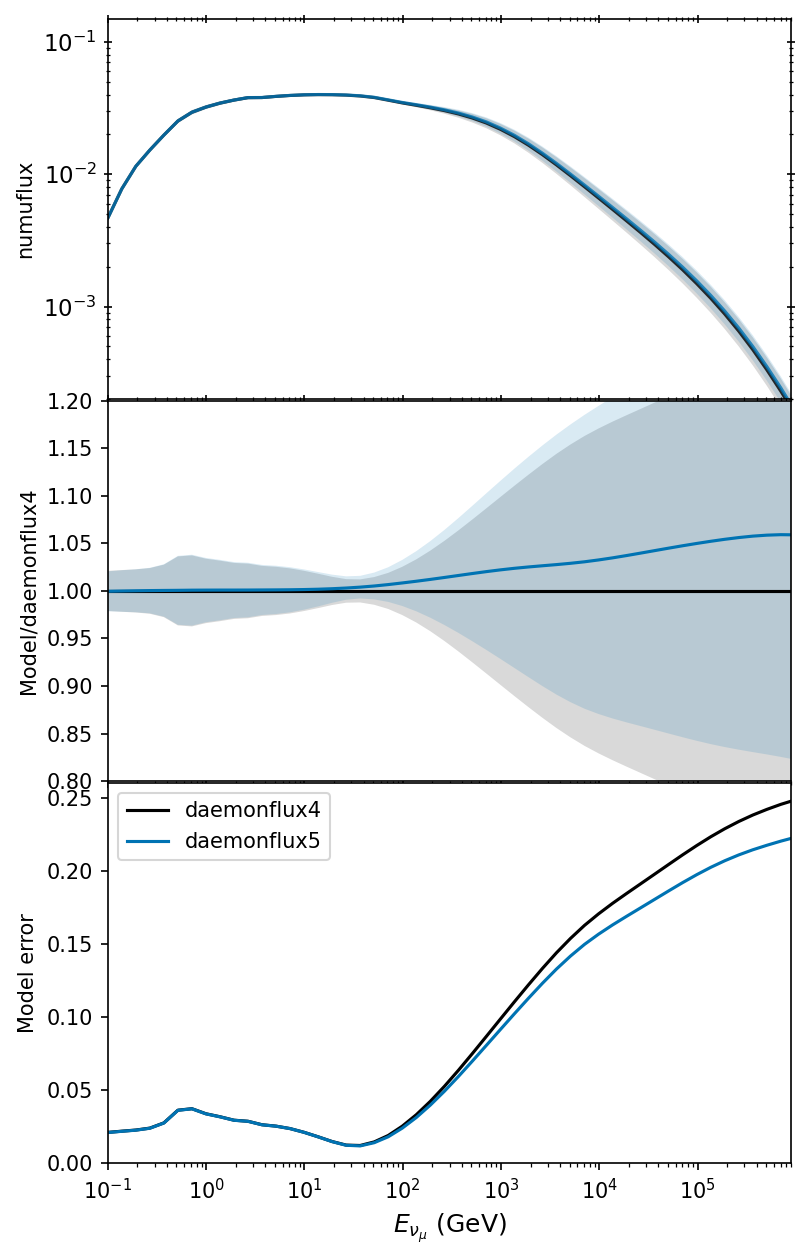

In [35]:
comparePlots(calibration_results, 
             reference=myref,
            particle = 'numuflux')

Using DAEMON quickflux
daemonflux4
/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/resources/daemonsplines_20230207_nousertab.pkl
Excluded params removed from known_params.
No calibration file for daemon-v3
Using DAEMON quickflux
daemonflux5
/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/resources/daemonsplines_20230207_nousertab.pkl
Excluded params removed from known_params.
No calibration file for daemon-v3


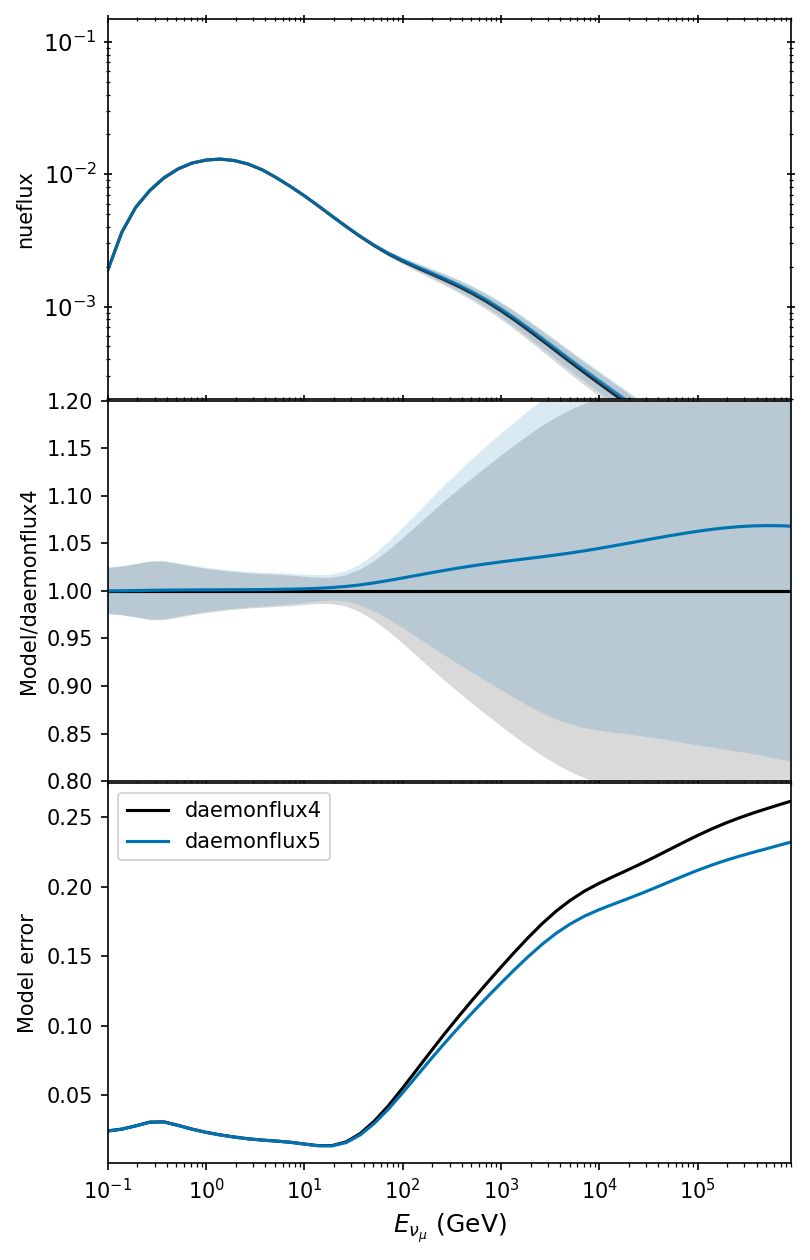

In [36]:
comparePlots(calibration_results, 
             reference=myref,
            particle = 'nueflux')

Using DAEMON quickflux
daemonflux4
/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/resources/daemonsplines_20230207_nousertab.pkl
Excluded params removed from known_params.
No calibration file for daemon-v3
Using DAEMON quickflux
daemonflux5
/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/resources/daemonsplines_20230207_nousertab.pkl
Excluded params removed from known_params.
No calibration file for daemon-v3


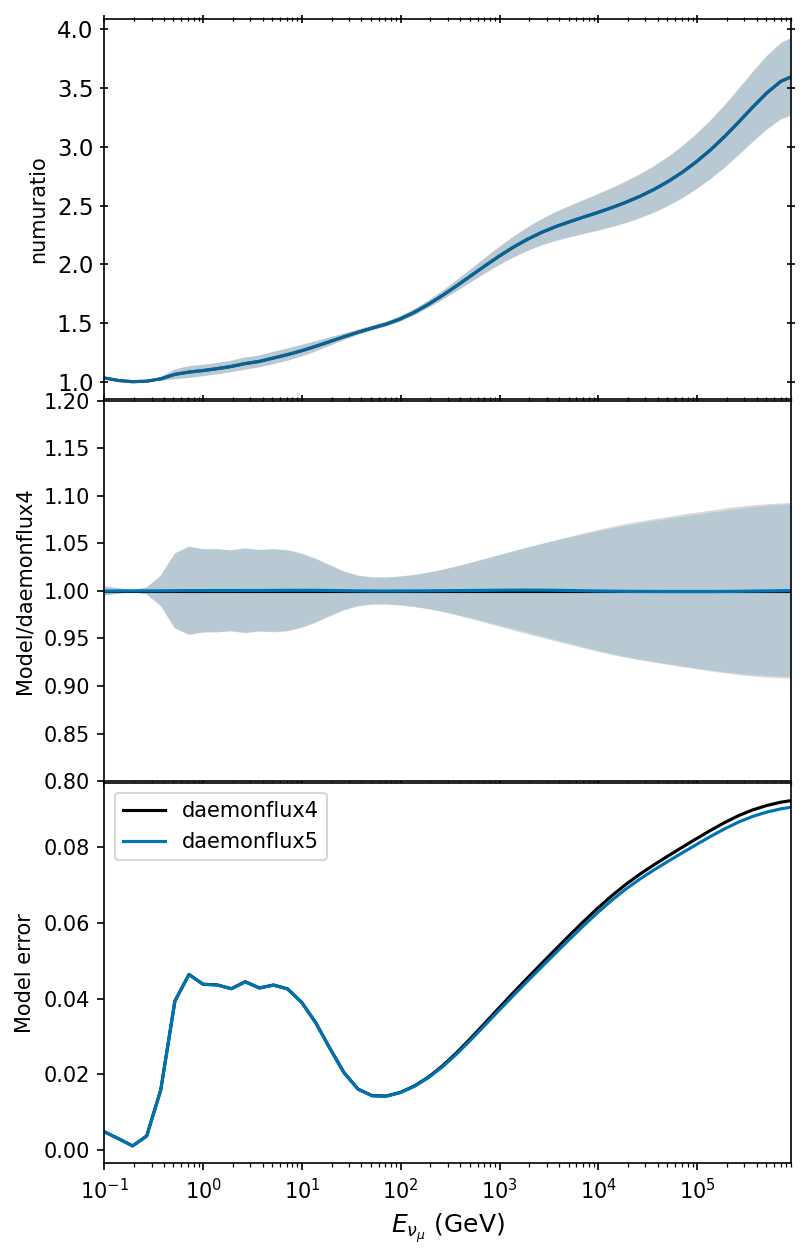

In [37]:
comparePlots(calibration_results, 
             reference=myref,
            particle = 'numuratio')

Using DAEMON quickflux
daemonflux4
/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/resources/daemonsplines_20230207_nousertab.pkl
Excluded params removed from known_params.
No calibration file for daemon-v3
Using DAEMON quickflux
daemonflux5
/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/resources/daemonsplines_20230207_nousertab.pkl
Excluded params removed from known_params.
No calibration file for daemon-v3


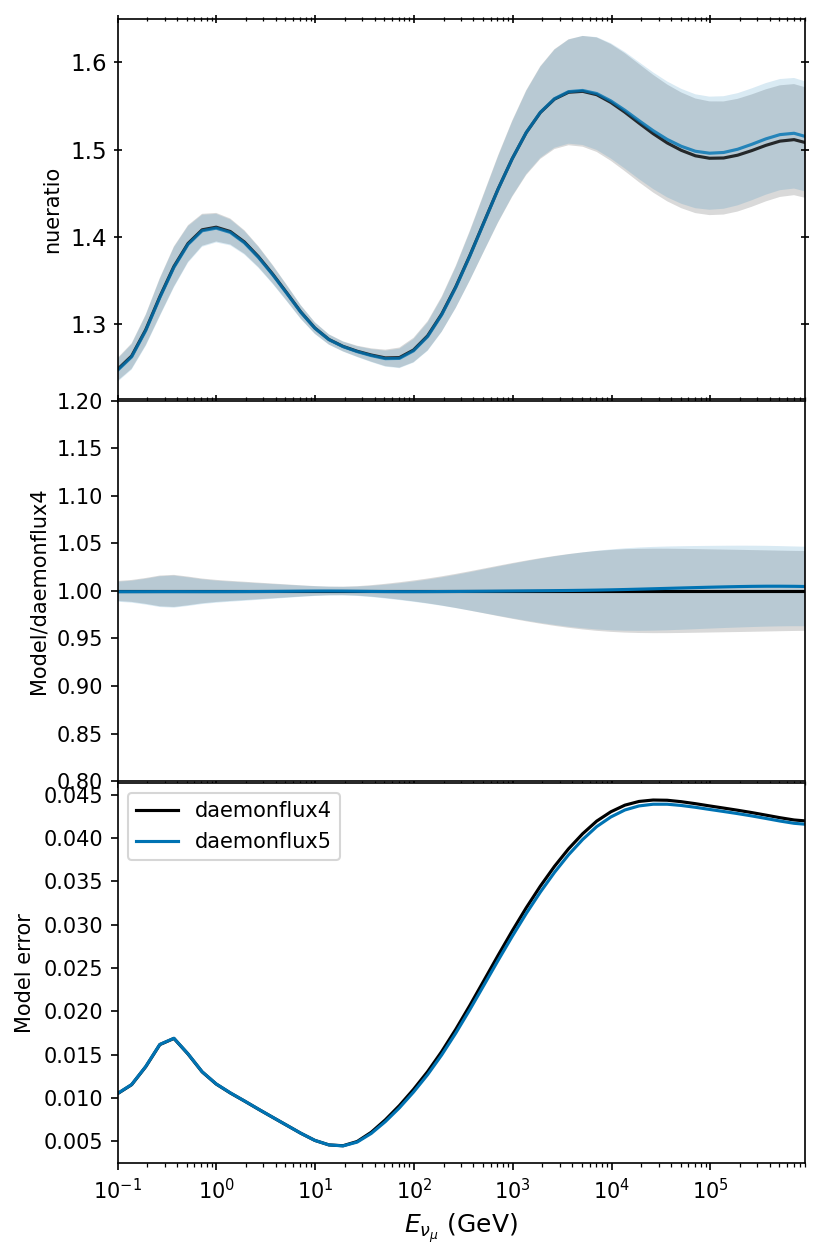

In [38]:
comparePlots(calibration_results, 
             reference=myref,
            particle = 'nueratio')

Using DAEMON quickflux
daemonflux4
/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/resources/daemonsplines_20230207_nousertab.pkl
Excluded params removed from known_params.
No calibration file for daemon-v3
Using DAEMON quickflux
daemonflux5
/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/resources/daemonsplines_20230207_nousertab.pkl
Excluded params removed from known_params.
No calibration file for daemon-v3


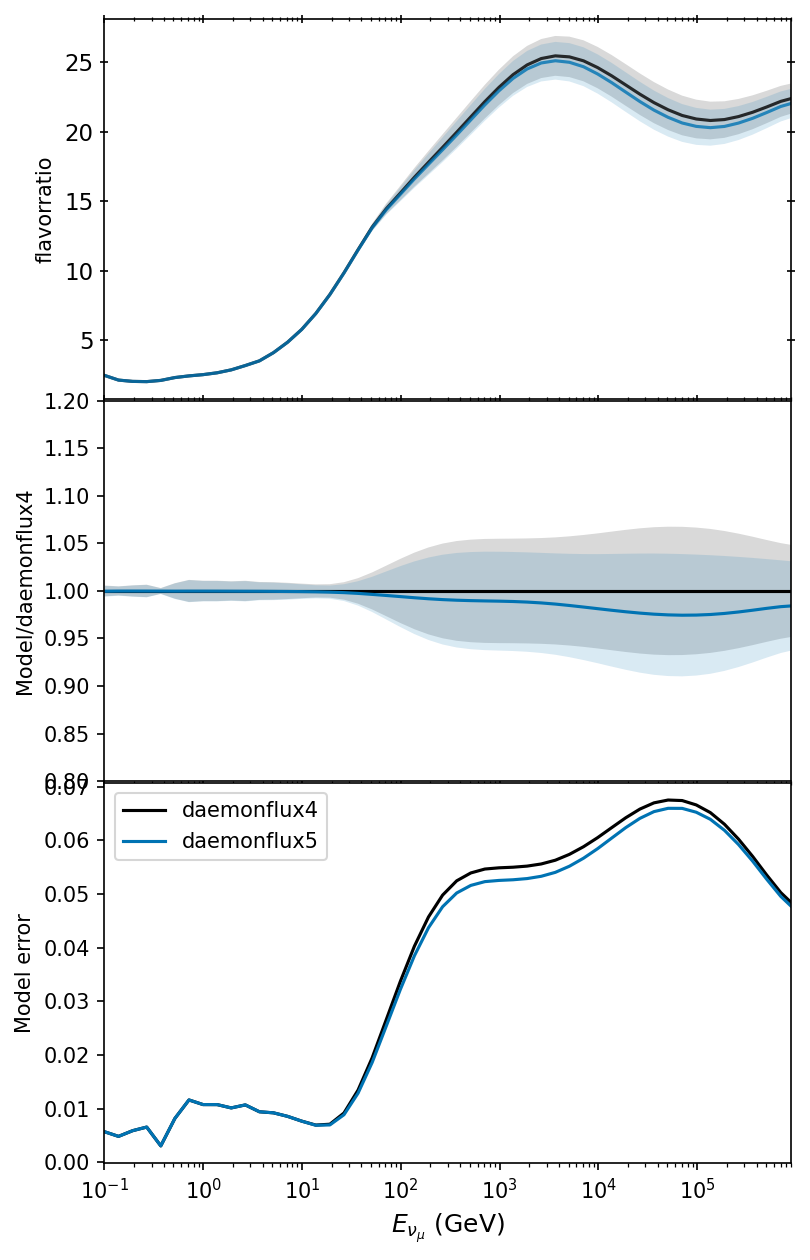

In [39]:
comparePlots(calibration_results, 
             reference=myref,
            particle = 'flavorratio')